<a href="https://colab.research.google.com/github/zergswim/GAN/blob/main/GANS_IN_ACTION_Chapter_5_DCGAN(Edited_to_WGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4장: 심층 합성곱 GAN (DCGAN)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/gans-in-action/blob/master/chapter-4/Chapter_4_DCGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
import tensorflow as tf
#print("TensorFlow version: ", tf.__version__)
#tf.debugging.set_log_device_placement(True)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#import os|
#os.environ["CUDA_VISIBLE_DEVICES"]='1'
#os.environ["CUDA_VISIBLE_DEVICES"]='0'

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10258576768474850875
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5218553000137910976
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [2]:
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터의 크기
z_dim = 100

## 생성자

In [3]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))

    return model

generator = build_generator(z_dim)
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      295040    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 64)       7

## 판별자

In [4]:
def build_discriminator(img_shape):

    model = Sequential()

    # 28x28x1에서 14x14x32 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    #POOL
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))

    # 14x14x32에서 7x7x64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    #POOL
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))

    # 7x7x64에서 3x3x128 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # sigmoid 활성화 함수를 사용한 출력층
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

    

## 모델 만들기

In [5]:
generator = build_generator(z_dim)
#generator.summary()
optimizer_g = tf.keras.optimizers.RMSprop(lr=1e-4)
optimizer_d = tf.keras.optimizers.RMSprop(lr=1e-4)
#optimizer_g = tf.keras.optimizers.Adam()
#optimizer_d = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean()

@tf.function
def gen_train_step(z, real):
    with tf.GradientTape() as gen_tape:
        gen_imgs = generator(z)
        pred = discriminator(gen_imgs)
        loss_g = tf.keras.losses.binary_crossentropy(real, pred) #? real or fake?
        #loss = -tf.math.reduce_mean(pred) #for WGAN

    gradients_g = gen_tape.gradient(loss_g, generator.trainable_variables)
    optimizer_g.apply_gradients(zip(gradients_g, generator.trainable_variables))

    train_loss(loss_g)
    g_loss = train_loss.result()
    
    return gen_imgs, g_loss

@tf.function
def dis_train_step(imgs, gen_imgs, real, fake):
    with tf.GradientTape() as dis_tape:
        pred_real = discriminator(imgs)
        pred_fake = discriminator(gen_imgs)
        loss_real = tf.keras.losses.binary_crossentropy(real, pred_real)
        loss_fake = tf.keras.losses.binary_crossentropy(fake, pred_fake)
        loss_d = (loss_real + loss_fake) /2
        #loss = -(tf.math.reduce_mean(pred_real) -tf.math.reduce_mean(pred_fake))

    gradients_d = dis_tape.gradient(loss_d, discriminator.trainable_variables)
    optimizer_d.apply_gradients(zip(gradients_d, discriminator.trainable_variables))

    train_loss(loss_d)
    d_loss = train_loss.result()
    
    accuracy = tf.math.reduce_mean(pred_real) - tf.math.reduce_mean(pred_fake)

    return d_loss, accuracy


# 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

discriminator.summary()
# # 생성자 모델 만들기
# generator = build_generator(z_dim)

# # 생성자를 훈련하는 동안 판별자의 파라미터를 유지
# discriminator.trainable = False

# # 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
# gan = build_gan(generator, discriminator)
# gan.compile(loss='binary_crossentropy', optimizer=Adam())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 2048)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## 훈련

In [6]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data()
    #(X_train, _), (_, _) = fashion_mnist.load_data()

    # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    import time
    start = time.time()  # 시작 시간 저장        

    for iteration in range(iterations):

        # 진짜 이미지에서 랜덤 배치 가져오기
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        # gen_imgs = generator.predict(z)

        # 생성자 훈련?
        gen_imgs, g_loss = gen_train_step(z, real)

        # 판별자 훈련
        # d_loss_real = discriminator.train_on_batch(imgs, real)
        # d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        # d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_loss, accuracy = dis_train_step(imgs, gen_imgs, real, fake)

        if (iteration + 1) % sample_interval == 0:

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
            # 생성된 이미지 샘플 출력
            sample_images(generator)

In [7]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

## GAN 훈련과 출력 점검

11501568/11490434 [==============================] - 0s 0us/step
1000 [D 손실: 0.706568, 정확도: 0.80%] [G 손실: 0.706575]
time : 56.36493968963623


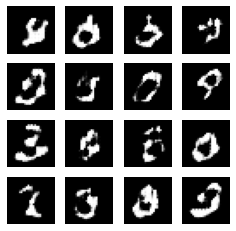

2000 [D 손실: 0.704094, 정확도: 1.78%] [G 손실: 0.704099]
time : 98.70960307121277


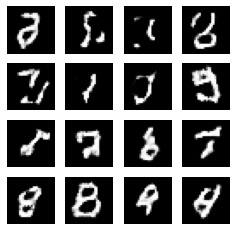

3000 [D 손실: 0.702778, 정확도: 2.85%] [G 손실: 0.702783]
time : 140.6933889389038


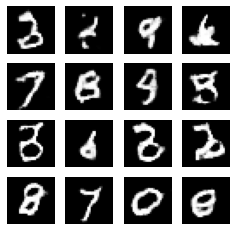

4000 [D 손실: 0.702080, 정확도: 3.38%] [G 손실: 0.702085]
time : 182.67759776115417


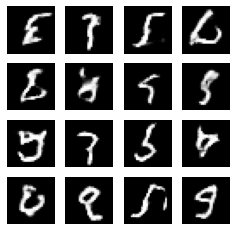

5000 [D 손실: 0.701929, 정확도: 4.92%] [G 손실: 0.701934]
time : 224.68751311302185


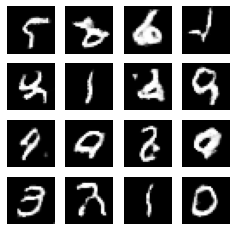

6000 [D 손실: 0.702287, 정확도: 5.07%] [G 손실: 0.702291]
time : 266.8508551120758


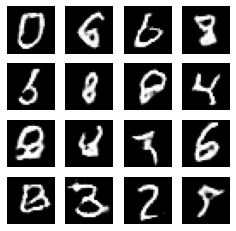

7000 [D 손실: 0.703012, 정확도: 5.09%] [G 손실: 0.703015]
time : 308.8553822040558


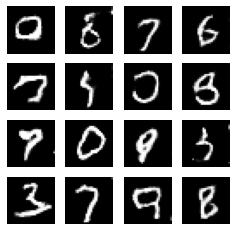

8000 [D 손실: 0.703917, 정확도: 7.38%] [G 손실: 0.703921]
time : 350.80890822410583


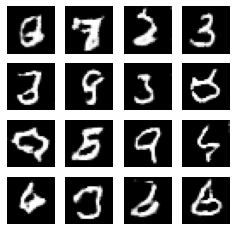

9000 [D 손실: 0.704909, 정확도: 8.57%] [G 손실: 0.704913]
time : 392.89617371559143


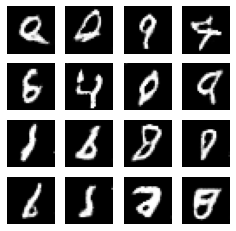

10000 [D 손실: 0.705968, 정확도: 6.65%] [G 손실: 0.705971]
time : 435.0666790008545


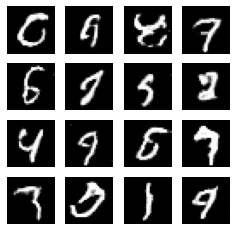

11000 [D 손실: 0.706988, 정확도: 8.00%] [G 손실: 0.706992]
time : 477.0532338619232


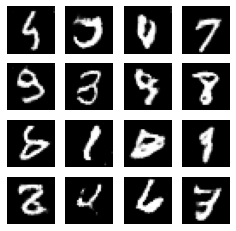

12000 [D 손실: 0.707983, 정확도: 10.95%] [G 손실: 0.707987]
time : 519.0211524963379


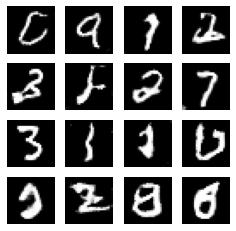

13000 [D 손실: 0.708966, 정확도: 7.62%] [G 손실: 0.708968]
time : 561.1911804676056


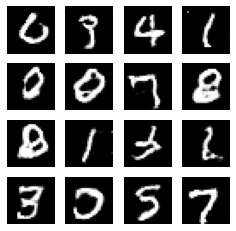

14000 [D 손실: 0.709957, 정확도: 10.63%] [G 손실: 0.709960]
time : 603.1423120498657


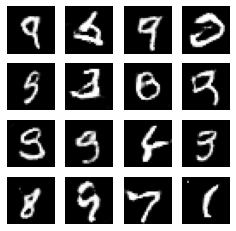

15000 [D 손실: 0.710923, 정확도: 11.95%] [G 손실: 0.710927]
time : 645.1899309158325


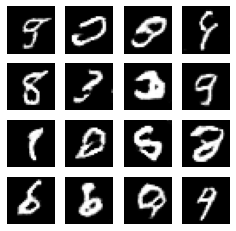

16000 [D 손실: 0.711892, 정확도: 7.21%] [G 손실: 0.711894]
time : 687.111499786377


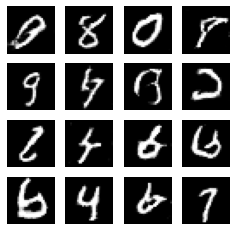

17000 [D 손실: 0.712846, 정확도: 10.85%] [G 손실: 0.712849]
time : 729.2389044761658


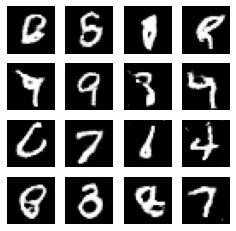

18000 [D 손실: 0.713765, 정확도: 10.50%] [G 손실: 0.713768]
time : 771.1663644313812


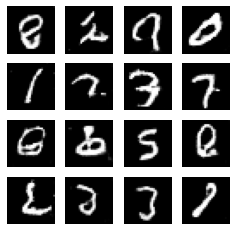

19000 [D 손실: 0.714690, 정확도: 10.54%] [G 손실: 0.714692]
time : 813.1339662075043


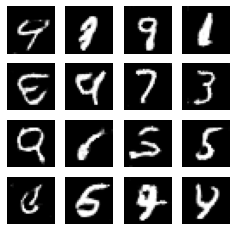

20000 [D 손실: 0.715582, 정확도: 9.88%] [G 손실: 0.715584]
time : 855.0831110477448


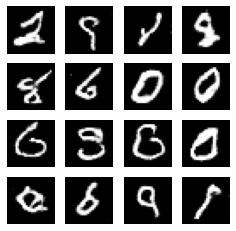

In [8]:
# 하이퍼파라미터 설정
iterations = 20000
batch_size = 128
sample_interval = 1000

# 지정된 반복 횟수만큼 DCGAN 훈련
train(iterations, batch_size, sample_interval)

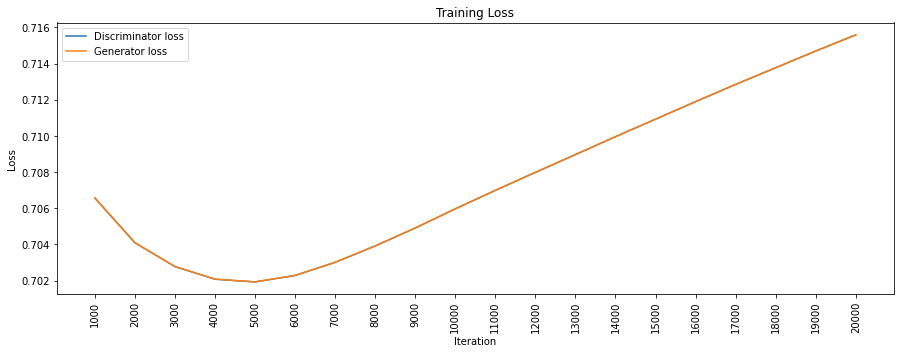

In [9]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

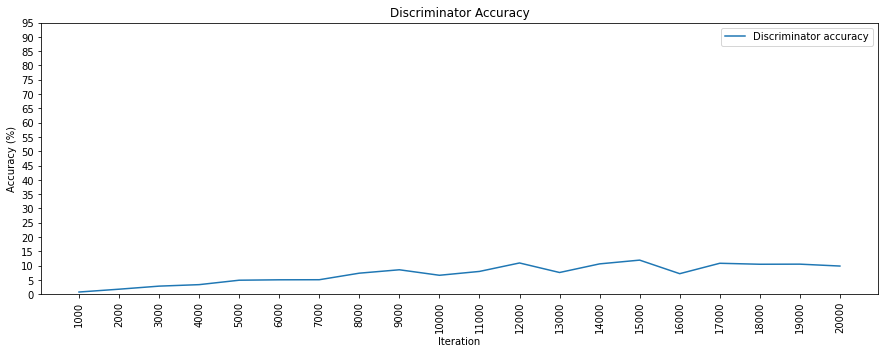

In [10]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()